# 6 DoF Pose from Semantic Keypoints #

The following is an implementation of https://www.seas.upenn.edu/~pavlakos/projects/object3d/
Find the associated tutorial at:https://medium.com/@vaishakvk/geometric-deep-learning-for-pose-estimation-6af45da05922

This is an adaptation of code used in Prof.Kostas Daniilidis' course. 

In [1]:
from __future__ import division
from __future__ import print_function

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from hourglass import hg
from tqdm import tqdm
from PIL import Image
import os
#from os import join
from time import time
import numpy as np
import cv2 
from utils import plot_mesh

os.makedirs('./output', exist_ok=True)

## Keypoint Localization ##

First, we will create the dataset class and a few transformations

In [2]:
class Dataset(Dataset):

    def __init__(self, dataset_dir='data', is_train=True, transform=None):
        self.dataset_dir = dataset_dir
        self.is_train = is_train
        self.transform = transform
        if is_train:
            data = np.load(os.path.join(dataset_dir, 'train_data.npz'))
        else:
            data = np.load(os.path.join(dataset_dir, 'valid_data.npz'))

        self.images = None

        self.imgname = data['imgname']
        self.keypoints = data['part']
        center = data['center']
        scale = data['scale']
        self.bb = np.vstack([data['center'][:,0]-data['scale']*100, data['center'][:,1]-data['scale']*100, data['scale']*200, data['scale']*200]).T
        self.keypoints = np.concatenate((self.keypoints, np.ones((self.keypoints.shape[0],10,1))), axis=-1)

    def __len__(self):
        return self.imgname.shape[0]

    def __getitem__(self, idx):
        # ensure there aren't conflicting file pointers
        if self.images is None:
            self.images = np.load(os.path.join(self.dataset_dir, 'images.npz'))

        image = self.images[self.imgname[idx].decode('utf-8')]
        image = Image.fromarray(image)

        b = self.bb[idx].copy()
        b[:2] = b[:2]
        b[2:] = b[2:]+b[0:2]
        bb = np.array([ [b[0], b[1]], [b[0], b[3]], [b[2], b[1]], [b[2], b[3]] ]) 
        keypoints = self.keypoints[idx].copy()
        item = {'image': image, 'bb': bb, 'keypoints': keypoints}
        if self.transform is not None:
            item = self.transform(item)
        return item

In [3]:
#Transformations

def generate_heatmap(heatmap, pt, sigma):
    heatmap[int(pt[1])][int(pt[0])] = 1
    heatmap = cv2.GaussianBlur(heatmap, sigma, 0)
    am = np.amax(heatmap)
    heatmap /= am
    return heatmap


class CropAndPad:

    def __init__(self, out_size=(256,256)):
        self.out_size = out_size[::-1]

    def __call__(self, sample):
        image, bb = sample['image'], sample['bb']
        img_size = image.size
        min_x, min_y = bb.min(axis=0)
        max_x, max_y = bb.max(axis=0)
        center_x = (min_x + max_x) / 2
        center_y = (min_y + max_y) / 2
        width = max([max_x-min_x, max_y-min_y])
        min_x = int(center_x) - int(width)//2
        min_y = int(center_y) - int(width)//2
        max_x = int(center_x) + int(width)//2
        max_y = int(center_y) + int(width)//2
        sample['image'] = image.crop(box=(min_x,min_y,max_x,max_y))
        sample['orig_image'] = image
        sample['center'] = np.array([center_x, center_y], dtype=np.float32)
        sample['min'] = np.array([min_x, min_y], dtype=np.float32)
        sample['scale'] = np.array([width/self.out_size[0]], dtype=np.float32)
        sample['width'] = width
        if width != self.out_size[0]:
            sample['image'] = sample['image'].resize(self.out_size)
        if 'mask' in sample:
            sample['mask'] = sample['mask'].crop(box=(min_x,min_y,max_x,max_y)).resize(self.out_size)
        if 'keypoints' in sample:
            keypoints = sample['keypoints']
            for i in range(keypoints.shape[0]):
                # if keypoints[i,2] != 0:
                if keypoints[i,0] < min_x or keypoints[i,0] > max_x or keypoints[i,1] < min_y or keypoints[i,1] > max_y:
                    keypoints[i,:] = [0,0,0]
                else:
                    keypoints[i,:2] = (keypoints[i,:2]-np.array([min_x, min_y]))*self.out_size/width
        sample['keypoints'] = keypoints
        sample.pop('bb')
        return sample

# Convert keypoint locations to heatmaps
class LocsToHeatmaps:

    def __init__(self, img_size=(256,256), out_size=(64,64), sigma=1):
        self.img_size = img_size
        self.out_size = out_size
        self.x_scale = 1.0 * out_size[0]/img_size[0]
        self.y_scale = 1.0 * out_size[1]/img_size[1]
        self.sigma=sigma
        x = np.arange(0, out_size[1], dtype=np.float)
        y = np.arange(0, out_size[0], dtype=np.float)
        self.yg, self.xg = np.meshgrid(y,x, indexing='ij')
        return

    def __call__(self, sample):
        sigma = 7
        gaussian_hm = np.zeros((self.out_size[0], self.out_size[1], sample['keypoints'].shape[0]))
        for i,keypoint in enumerate(sample['keypoints']):
            if keypoint[2] != 0:
                gaussian_hm[:,:,i] = generate_heatmap(gaussian_hm[:,:,i], tuple(keypoint[:-1].astype(np.int) * self.x_scale), (sigma, sigma))
        sample['keypoint_locs'] = sample['keypoints'][:,:2]
        sample['visible_keypoints'] = sample['keypoints'][:,2]
        sample['keypoint_heatmaps'] = gaussian_hm
        return sample

# Convert numpy arrays to Tensor objects
# Permute the image dimensions
class ToTensor:

    def __init__(self, downsample_mask=False):
        self.tt = transforms.ToTensor()
        self.downsample_mask=downsample_mask

    def __call__(self, sample):
        sample['image'] = self.tt(sample['image'])
        if 'orig_image' in sample:
            sample['orig_image'] = self.tt(sample['orig_image'])
        if 'mask' in sample:
            if self.downsample_mask:
                sample['mask'] = self.tt(sample['mask'].resize((64,64), Image.ANTIALIAS))
            else:
                sample['mask'] = self.tt(sample['mask'])
        if 'in_mask' in sample:
            sample['in_mask'] = self.tt(sample['in_mask'])
            # sample['in_mask'] = sample['in_mask'].unsqueeze(0)
        if 'keypoint_heatmaps' in sample:
            sample['keypoint_heatmaps'] =\
                torch.from_numpy(sample['keypoint_heatmaps'].astype(np.float32).transpose(2,0,1))
            sample['keypoint_locs'] =\
                torch.from_numpy(sample['keypoint_locs'].astype(np.float32))
            sample['visible_keypoints'] =\
                torch.from_numpy(sample['visible_keypoints'].astype(np.float32))
        return sample

class Normalize:

    def __call__(self, sample):
        sample['image'] = 2*(sample['image']-0.5)
        if 'in_mask' in sample:
            sample['in_mask'] = 2*(sample['in_mask']-0.5)
        return sample

In [4]:
class Trainer(object):

    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        train_transform_list = [CropAndPad(out_size=(256, 256)),LocsToHeatmaps(out_size=(64, 64)),ToTensor(),Normalize()]
        test_transform_list = [CropAndPad(out_size=(256, 256)),LocsToHeatmaps(out_size=(64, 64)),ToTensor(),Normalize()]
        self.train_ds = Dataset(is_train=True, transform=transforms.Compose(train_transform_list))
        self.test_ds = Dataset(is_train=False, transform=transforms.Compose(test_transform_list))

        self.model = hg(num_stacks=1, num_blocks=1, num_classes=10).to(self.device)
        # define loss function and optimizer
        self.heatmap_loss = torch.nn.MSELoss().to(self.device) # for Global loss
        self.optimizer = torch.optim.RMSprop(self.model.parameters(),
                                             lr = 2.5e-4)
        self.train_data_loader = DataLoader(self.train_ds, batch_size=8,
                                            num_workers=8,
                                            pin_memory=True,
                                            shuffle=True)
        self.test_data_loader = DataLoader(self.test_ds, batch_size=32,
                                           num_workers=8,
                                           pin_memory=True,
                                           shuffle=True)

        self.summary_iters = []
        self.losses = []
        self.pcks = []

    def train(self):
        self.total_step_count = 0
        start_time = time()
        for epoch in range(1,400+1):

            print("Epoch %d/%d"%
                    (epoch,400))

            for step, batch in enumerate(self.train_data_loader):
                self.model.train()
                batch = {k: v.to(self.device) if isinstance(v, torch.Tensor) else v for k,v in batch.items()}
                self.optimizer.zero_grad()
                pred_heatmap_list = self.model(batch['image'])
                loss = self.heatmap_loss(pred_heatmap_list[-1], batch['keypoint_heatmaps'])
                loss.backward()
                self.optimizer.step()                                          
                
                self.total_step_count += 1


        checkpoint = {'model': self.model.state_dict()}
        torch.save(checkpoint, './output/model_checkpoint.pt')

In [5]:
trainer = Trainer()
trainer.train()

Epoch 1/400
Epoch 2/400
Epoch 3/400
Epoch 4/400
Epoch 5/400
Epoch 6/400
Epoch 7/400
Epoch 8/400
Epoch 9/400
Epoch 10/400
Epoch 11/400
Epoch 12/400
Epoch 13/400
Epoch 14/400
Epoch 15/400
Epoch 16/400
Epoch 17/400
Epoch 18/400
Epoch 19/400
Epoch 20/400
Epoch 21/400
Epoch 22/400
Epoch 23/400
Epoch 24/400
Epoch 25/400
Epoch 26/400
Epoch 27/400
Epoch 28/400
Epoch 29/400
Epoch 30/400
Epoch 31/400
Epoch 32/400
Epoch 33/400
Epoch 34/400
Epoch 35/400
Epoch 36/400
Epoch 37/400
Epoch 38/400
Epoch 39/400
Epoch 40/400
Epoch 41/400
Epoch 42/400
Epoch 43/400
Epoch 44/400
Epoch 45/400
Epoch 46/400
Epoch 47/400
Epoch 48/400
Epoch 49/400
Epoch 50/400
Epoch 51/400
Epoch 52/400
Epoch 53/400
Epoch 54/400
Epoch 55/400
Epoch 56/400
Epoch 57/400
Epoch 58/400
Epoch 59/400
Epoch 60/400
Epoch 61/400
Epoch 62/400
Epoch 63/400
Epoch 64/400
Epoch 65/400
Epoch 66/400
Epoch 67/400
Epoch 68/400
Epoch 69/400
Epoch 70/400
Epoch 71/400
Epoch 72/400
Epoch 73/400
Epoch 74/400
Epoch 75/400
Epoch 76/400
Epoch 77/400
Epoch 78

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = hg(num_stacks=1, num_blocks=1, num_classes=10).to(device)
checkpoint = torch.load('./output/model_checkpoint.pt')
model.load_state_dict(checkpoint['model'])
transform_list = [CropAndPad(out_size=(256, 256))]
transform_list.append(LocsToHeatmaps(out_size=(64,64)))
transform_list.append(ToTensor())
transform_list.append(Normalize())
test_ds = Dataset(is_train=False, transform=transforms.Compose(transform_list))
data_loader = DataLoader(test_ds, batch_size=1, pin_memory=True, shuffle=False)
predicted_heatmaps = np.zeros((len(test_ds), 10, 64, 64))
for i, batch in enumerate(tqdm(data_loader)):
    model.eval()
    images = batch['image'].to(device)
    with torch.no_grad():
        pred_heatmap_list = model(images)
    pred_heatmaps = pred_heatmap_list[-1]
    predicted_heatmaps[i,:,:,:] = pred_heatmaps[0,:,:,:].cpu().numpy()
np.save('./output/detections.npy', predicted_heatmaps)

100%|██████████| 27/27 [00:00<00:00, 60.46it/s]


## Pose Optimization##

In [7]:
"""
Convert axis-angle representation to a 3x3 rotation matrix
"""
class Rodrigues(torch.autograd.Function):
    @staticmethod
    def forward(self, inp):
        pose = inp.detach().cpu().numpy()
        rotm, part_jacob = cv2.Rodrigues(pose)
        self.jacob = torch.Tensor(np.transpose(part_jacob)).contiguous()
        rotation_matrix = torch.Tensor(rotm.ravel())
        return rotation_matrix.view(3,3)

    @staticmethod
    def backward(self, grad_output):
        grad_output = grad_output.view(1,-1)
        grad_input = torch.mm(grad_output, self.jacob)
        grad_input = grad_input.view(-1)
        return grad_input

rodrigues = Rodrigues.apply

In [8]:
def pose_optimization(img, vertices, faces, keypoints_2d, conf, keypoints_3d, K):
    # Send variables to GPU
    device = keypoints_2d.device
    keypoints_3d = keypoints_3d.to(device)
    K = K.to(device)
    r = torch.rand(3, requires_grad=True, device=device) # rotation in axis-angle representation
    t = torch.rand(3 ,requires_grad=True, device=device)
    d = conf.sqrt()[:, None]
    # 2D keypoints in normalized coordinates
    norm_keypoints_2d = torch.matmul(K.inverse(), torch.cat((keypoints_2d, torch.ones(keypoints_2d.shape[0],1, device=device)), dim=-1).t()).t()[:,:-1]
    # set up optimizer
    optimizer = torch.optim.Adam([r,t], lr=1e-2)
    # converge check
    converged = False
    rel_tol = 1e-7
    loss_old = 100
    while not converged:
      optimizer.zero_grad()
      # convert axis-angle to rotation matrix
      R = rodrigues(r)
      # 1) Compute projected keypoints based on current estimate of R and t
      k3d = torch.matmul(R, keypoints_3d.transpose(1, 0)) + t[:, None]
      proj_keypoints = (k3d / k3d[2])[0:2,:].transpose(1,0) 
      # 2) Compute error (based on distance between projected keypoints and detected keypoints)
      err = torch.norm(((norm_keypoints_2d - proj_keypoints)*d)**2, 'fro')
      # 3) Update based on error
      err.backward()
      optimizer.step()
      # 4) Check for convergence
      if abs(err.detach() - loss_old)/loss_old < rel_tol:
        break
      else:
        loss_old = err.detach()    
        
#       print(err.detach().cpu().numpy())

    R = rodrigues(r)
    plt.figure()
    plot_mesh(img, vertices, faces, R.detach().cpu().numpy(), t.detach().cpu().numpy()[:,None], K.detach().cpu().numpy())
    plt.show()
    return rodrigues(r)[0].detach(), t.detach()


def heatmaps_to_locs(heatmaps):
    heatmaps = heatmaps.numpy()
    conf = np.max(heatmaps, axis=(-2,-1))
    locs = np.argmax(heatmaps.reshape((*heatmaps.shape[:2], -1)), axis=-1)
    locs = np.stack(np.unravel_index(locs, (64, 64))[::-1], axis=-1) # reverse x,y
    return torch.from_numpy(np.concatenate([locs, conf[..., None]], axis=-1).astype('float32'))

Processing  train_148.jpg


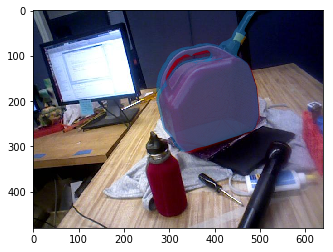

Processing  train_160.jpg


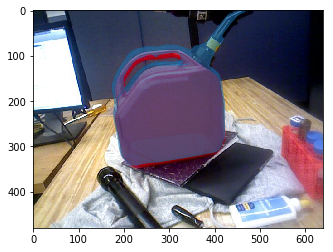

Processing  train_80.jpg


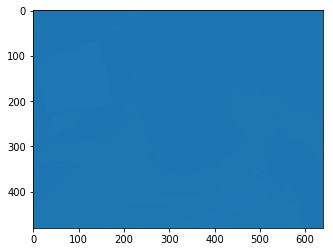

Processing  train_181.jpg


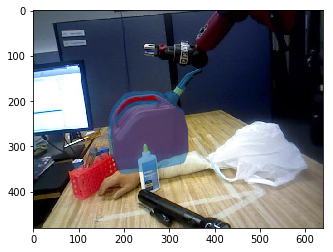

Processing  train_176.jpg


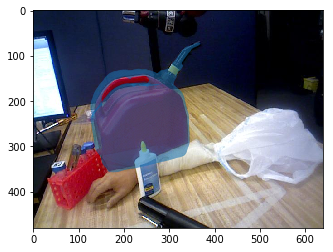

Processing  train_2.jpg


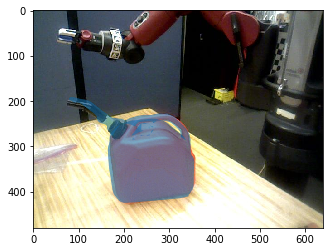

Processing  train_155.jpg


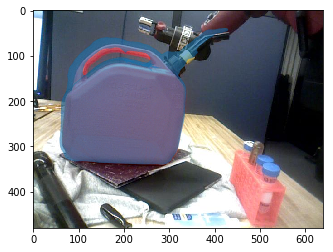

Processing  train_136.jpg


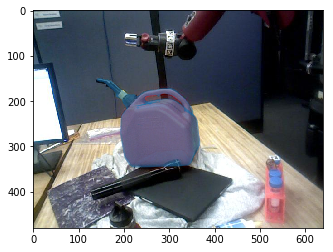

Processing  train_4.jpg


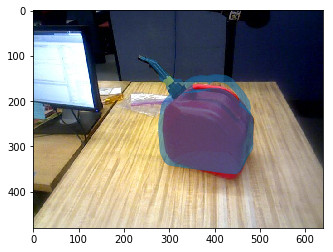

Processing  train_18.jpg


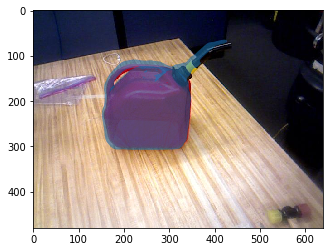

Processing  train_106.jpg


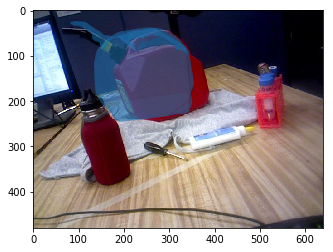

Processing  train_90.jpg


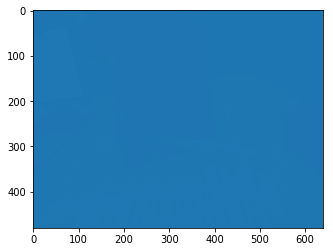

Processing  train_25.jpg


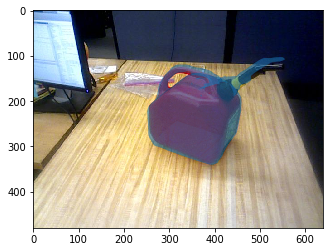

Processing  train_116.jpg


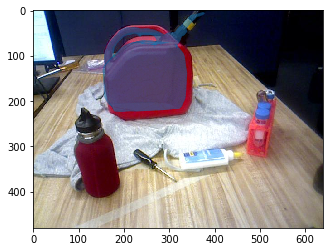

Processing  train_190.jpg


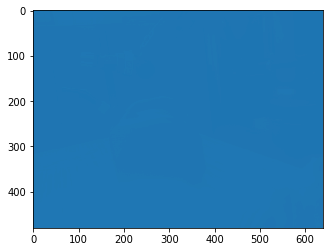

Processing  train_177.jpg


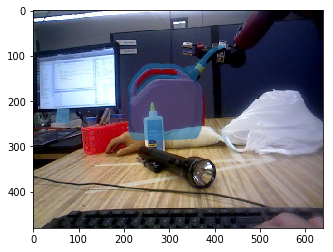

Processing  train_52.jpg


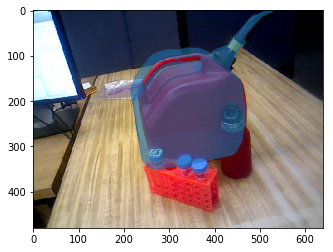

Processing  train_191.jpg


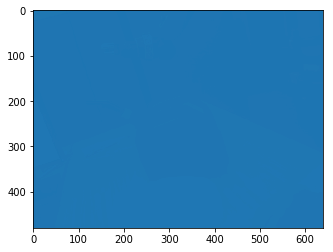

Processing  train_13.jpg


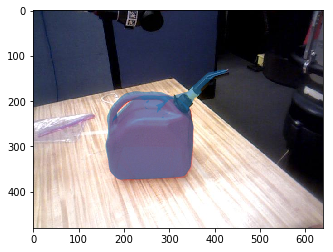

Processing  train_9.jpg


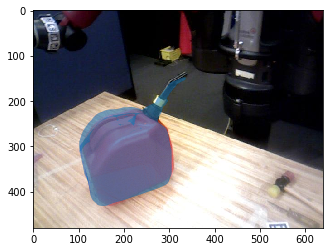

Processing  train_81.jpg


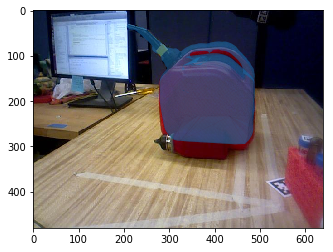

Processing  train_21.jpg


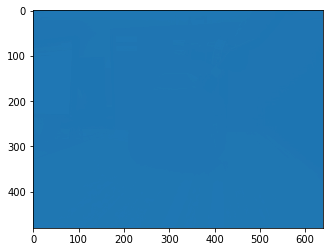

Processing  train_72.jpg


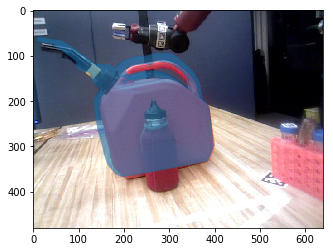

Processing  train_144.jpg


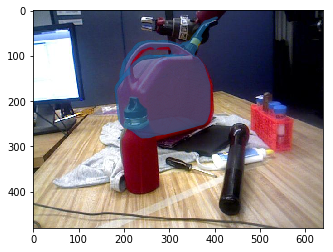

Processing  train_10.jpg


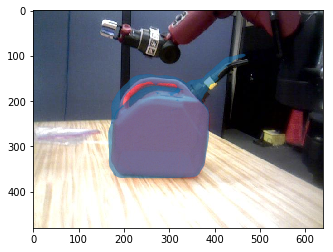

Processing  train_12.jpg


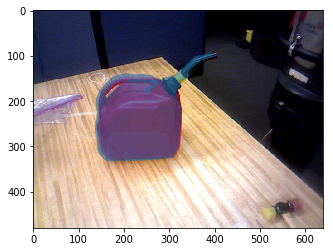

Processing  train_140.jpg


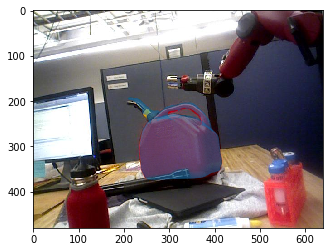

In [9]:
data = np.load('data/misc_data.npz')
K = torch.from_numpy(data['K']).float()
S = torch.from_numpy(np.load('data/kpt.npy'))
vertices = data['vertices']
faces = data['faces']

dataset = np.load('data/valid_data.npz')
imgnames = dataset['imgname']
scales = torch.from_numpy(dataset['scale']).float()[:,None]
centers = torch.from_numpy(dataset['center']).float()
# detections.npy contains the detections saved after training your model and running predict.py
heatmaps = torch.from_numpy(np.load('./output/detections.npy'))

keypoint_locs = heatmaps_to_locs(heatmaps)

# Compute detected 2D keypoint locations in the original image
ul_corner = centers - scales * 100
keypoint_locs[:,:,:-1] *= scales[:,:,None]*200 / 64
keypoint_locs[:,:,:-1] += ul_corner[:,None,:]

images = np.load('data/images.npz')
for i in range(len(heatmaps)):
    img_name = imgnames[i].decode('utf-8')
    print("Processing ", img_name)
    img = images[img_name]
    pose_optimization(img, vertices, faces, keypoint_locs[i,:,:-1], keypoint_locs[i,:,-1], S, K)
    plt.close('all')